## CSC 215 - Project 2
### Khoi Hoang
### William Dobson

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
%matplotlib inline

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


In [3]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### Convert JSON data into tabular format for Pandas

In [ ]:
#reviews.json
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

In [ ]:
#business.json
outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'review_count', 'categories'])
with open('business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], row['review_count'], row['categories']])

outfile.close()

In [ ]:
#tip.json
outfile = open("tip.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','text'])
with open('tip.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], (row['text']).encode('utf-8')])

outfile.close()

In [5]:
df_review= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")
df_business= pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8")
df_tip= pd.read_csv('tip.tsv', delimiter ="\t", encoding="utf-8")
df_tip[0:5]

,business_id,text
0,VaKXUpmWTTWDKbpJ3aQdMw,"b'Great for watching games, ufc, and whatever ..."
1,OPiPeoJiv92rENwbq76orA,b'Happy Hour 2-4 daily with 1/2 price drinks a...
2,5KheTjYPu1HcQzQFtm4_vw,b'Good chips and salsa. Loud at times. Good se...
3,TkoyGi8J7YFjA6SbaRzrxg,b'The setting and decoration here is amazing. ...
4,AkL6Ous6A1atZejfZXn1Bg,b'Molly is definately taking a picture with Sa...


In [6]:
df_review.head()

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...


In [7]:
#only consider reviews that have more than 50 characters
df_review = df_review[df_review['text'].str.len() >= 50]
df_review.shape

(6678404, 3)

In [8]:
df_tip = df_tip[df_tip['text'].str.len() >= 20]
df_tip.shape

(1094522, 2)

In [9]:
#group all reviews by each business and create a new dataframe, where each line is a business with all its reviews
df_review_agg = df_review.groupby('business_id')['text'].sum()

df_all_reviews = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

In [10]:
#group all tip by each business and create a new dataframe, where each line is a business with all its tips
df_tip_agg = df_tip.groupby('business_id')['text'].sum()

df_all_tips = pd.DataFrame({'business_id': df_tip_agg.index, 'all_tips': df_tip_agg.values})

In [11]:
df_all_tips.head()

,business_id,all_tips
0,--1UhMGODdWsrMastO9DZw,"b""Delicious! One of the best burritos, salsa a..."
1,--6MefnULPED_I942VcFNA,b'BBQ pork is sold out early on Saturday'b'The...
2,--7zmmkVg-IMGaXbuVd0SQ,"b""Good place to stop when traffic don't go.""b'..."
3,--9QQLMTbFzLJ_oT-ON3Xw,"b""Tip? Don't get your hair cut here. If they'r..."
4,--9e1ONYQuAa-CB_Rrw7Tw,b'Wine pairings for my prix fixe meal. Mmmm'b...


#### Only consider businesses which have more than 20 reviews

In [12]:
df_business = df_business[df_business['review_count'] >= 20]
df_business.shape

(57644, 4)

In [13]:
#merge df_business, df_all_reviews, and df_all_tips by business_id
df_ready_for_sklearn = pd.merge(pd.merge(df_all_reviews, df_business, on='business_id', how='inner'), df_all_tips, on='business_id', how='inner')
#df_ready_for_sklearn = pd.merge(df_all_reviews, df_business, on='business_id', how='inner')
df_ready_for_sklearn.shape

(54657, 6)

In [14]:
df_ready_for_sklearn.isnull().any()

business_id     False
all_reviews     False
stars           False
review_count    False
categories       True
all_tips        False
dtype: bool

In [15]:
#label encode the stars
le = preprocessing.LabelEncoder()
df_ready_for_sklearn['encoded_stars'] = le.fit_transform(df_ready_for_sklearn['stars'])

In [16]:
print(df_ready_for_sklearn.shape)
df_ready_for_sklearn[0:5]

(54657, 7)


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,4.0,24,"Restaurants, Mexican","b""Delicious! One of the best burritos, salsa a...",6
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",3.0,44,"Chinese, Restaurants",b'BBQ pork is sold out early on Saturday'b'The...,4
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",4.0,58,"Breweries, Food","b""Good place to stop when traffic don't go.""b'...",6
3,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,4.0,1613,"Cajun/Creole, Seafood, Steakhouses, Restaurants",b'Wine pairings for my prix fixe meal. Mmmm'b...,6
4,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,3.5,49,"Restaurants, Breakfast & Brunch",b'Awesome. Huge portions definitely worth a v...,5


## Split the data and prepare for training and testing

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df_ready_for_sklearn, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [18]:
x_train['review_count_zscore'] = zscore(x_train['review_count'])
x_train[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53526,ygcX18rboNOaYnNmRCDytw,b'I drive 45 minutes from Cleveland to enjoy t...,4.0,30,"Restaurants, Cafes, Tea Rooms, Bubble Tea, Food",b'cute shop and helpful staff!'b'The greatest ...,6,-0.374402
16481,IB_aESRBh2cmYWSF6Fv0jQ,b'I was really happy with Spencer\'s when I pu...,3.0,94,"Home & Garden, Shopping, Appliances, Electronics",b'Best pricing in town.Next day delivery great...,4,-0.021752
21744,OI_lS_aamMgjnHqNlaO2rA,"b""For a post office, this location is pretty g...",2.5,21,"Public Services & Government, Local Services, ...","b""Kinda old school. Feels weird. Have to Stand...",3,-0.423993
49426,tyQWsZUSoMuoX6_5pcCE8Q,"b""Honestly the worst latte I've ever had. Got ...",4.5,108,"Coffee & Tea, Coffee Roasteries, Food",b'Cute simple coffee shop. Great coffee and th...,7,0.055390
23280,Q7rrhu3FJxTASTo46pT9vA,"b""It tastes great and the atmosphere is great ...",3.5,101,"Coffee & Tea, Food",b'$3 cappuccino is a pretty sweet deal. I have...,5,0.016819


In [19]:
x_test['review_count_zscore'] = zscore(x_test['review_count'])
x_test[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53763,yyiHkabQBtLifVTsO1r1kw,"b""I am not the biggest fan of Walmart but they...",3.0,37,"Food, Shopping, Grocery, Fashion, Drugstores, ...",b'Picking up some goodies for E.B.!'b'Rich wal...,4,-0.293785
50802,vZu12JAudoXBv3-i0JmSiQ,"b""I brought a watch strap in to get a few link...",3.0,29,"Shopping, Jewelry, Watch Repair, Local Service...",b'5 mins in and out for a battery replacement....,4,-0.330296
54033,zIpW3YlE9fFwyWOT5HGI6A,"b""Only giving one star cuz I have to. Terrible...",2.0,41,"Fast Food, Ice Cream & Frozen Yogurt, Restaura...","b""Get better employees and listen to what peop...",2,-0.275530
27076,UaL6yRGSv9fYCyn2DJLu8w,"b'Greek salad add avacado, very fresh very del...",4.5,42,"Food, Juice Bars & Smoothies, Restaurants, Cof...","b'Love this place. Good food, fresh as fuck ju...",7,-0.270966
14056,FML0YqZ7dLBBC3Suap4_4Q,"b""My favourite place in the city! Great vibe a...",4.0,296,"Nightlife, Restaurants, Tapas/Small Plates, Bars",b'Most of the food is made in house'b'All is g...,6,0.888237


In [20]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

In [21]:
#obtain tfidf score for reviews
#vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

reviews_matrix_train = vectorizer.fit_transform(x_train['all_reviews'])
reviews_tfidf_train = reviews_matrix_train.toarray()

reviews_matrix_test = vectorizer.transform(x_test['all_reviews'])
reviews_tfidf_test = reviews_matrix_test.toarray()

#vectorizer.get_feature_names()

In [22]:
y_train.head()

53526    4.0
16481    3.0
21744    2.5
49426    4.5
23280    3.5
Name: stars, dtype: float64

In [23]:
#obtain tfidf score for tips
#vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

tips_matrix_train = vectorizer.fit_transform(x_train['all_tips'])
tips_tfidf_train = tips_matrix_train.toarray()

tips_matrix_test = vectorizer.transform(x_test['all_tips'])
tips_tfidf_test = tips_matrix_test.toarray()

vectorizer.get_feature_names()

['10',
 '11',
 '15',
 '20',
 '30',
 '50',
 '99',
 'absolutely',
 'amazing',
 'area',
 'ask',
 'atmosphere',
 'authentic',
 'available',
 'away',
 'awesome',
 'bad',
 'bar',
 'beautiful',
 'beef',
 'beer',
 'best',
 'better',
 'big',
 'bit',
 'bomb',
 'bread',
 'breakfast',
 'bring',
 'burger',
 'business',
 'busy',
 'buy',
 'came',
 'card',
 'cash',
 'cheap',
 'check',
 'cheese',
 'chicken',
 'chocolate',
 'clean',
 'close',
 'closed',
 'coffee',
 'cold',
 'come',
 'coming',
 'cool',
 'cream',
 'customer',
 'day',
 'deal',
 'decent',
 'definitely',
 'delicious',
 'did',
 'didn',
 'different',
 'dinner',
 'disappointed',
 'does',
 'don',
 'drink',
 'drinks',
 'drive',
 'early',
 'eat',
 'enjoy',
 'excellent',
 'experience',
 'extra',
 'family',
 'fantastic',
 'far',
 'fast',
 'favorite',
 'feel',
 'fish',
 'flavor',
 'food',
 'free',
 'fresh',
 'friday',
 'fried',
 'friendly',
 'friends',
 'fries',
 'fun',
 'getting',
 'going',
 'good',
 'got',
 'great',
 'green',
 'guys',
 'half',
 'ha

In [29]:
temp = x_train['review_count_zscore'].values
input_data_train = np.column_stack((reviews_tfidf_train, tips_tfidf_train))
input_data_train = np.column_stack((input_data_train, temp))
#input_data_train = np.column_stack((reviews_tfidf_train, temp))
#input_data_train.shape

temp = x_test['review_count_zscore'].values
input_data_test = np.column_stack((reviews_tfidf_test, tips_tfidf_test))
input_data_test = np.column_stack((input_data_test, temp))
#input_data_test = np.column_stack((reviews_tfidf_test, temp))
input_data_test.shape

(13665, 501)

In [36]:
input_data_test.shape

(13665, 501)

In [37]:
#convert into dataframe
df_train = pd.DataFrame(input_data_train)
df_test = pd.DataFrame(input_data_test)
df_train['stars'] = y_train.values
df_test['stars'] = y_test.values
#df_train.dropna()
#missing_median(df_train, 'stars')
#missing_median(df_test, 'stars')

In [38]:
df_test.isnull().values.any()

False

In [39]:
df_train.shape

(40992, 502)

In [40]:
x_train_tf,y_train_tf = to_xy(df_train,'stars')

In [41]:
x_test_tf,y_test_tf = to_xy(df_test,'stars')

In [42]:
y_train_tf

array([4. , 3. , 2.5, ..., 3.5, 4. , 4. ], dtype=float32)

# Tensorflow

### Regression model

In [81]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

In [50]:
checkpointer = ModelCheckpoint(filepath=".\lowest_error.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(10):
    print(i)
    
    #Build network
    model = Sequential()

    model.add(Dense(25, input_dim=x_train_tf.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dense(10, activation='relu')) # Hidden 2
    #model.add(Dense(30, activation='relu')) # Hidden 3
    #model.add(Dense(20, activation='relu')) # Hidden 4
    model.add(Dense(1)) # Output

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    #checkpointer = ModelCheckpoint(filepath=".\lowest_error.hdf5", verbose=0, save_best_only=True) # save best model


    model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\lowest_error.hdf5') # load weights from best model

0
Train on 40992 samples, validate on 13665 samples
Epoch 1/1000
 - 5s - loss: 0.5822 - val_loss: 0.1584
Epoch 2/1000
 - 4s - loss: 0.1332 - val_loss: 0.1170
Epoch 3/1000
 - 4s - loss: 0.1064 - val_loss: 0.1127
Epoch 4/1000
 - 4s - loss: 0.0977 - val_loss: 0.1030
Epoch 5/1000
 - 4s - loss: 0.0926 - val_loss: 0.0991
Epoch 6/1000
 - 4s - loss: 0.0893 - val_loss: 0.0973
Epoch 7/1000
 - 4s - loss: 0.0868 - val_loss: 0.0982
Epoch 8/1000
 - 4s - loss: 0.0849 - val_loss: 0.0978
Epoch 9/1000
 - 4s - loss: 0.0832 - val_loss: 0.1004
Epoch 10/1000
 - 4s - loss: 0.0812 - val_loss: 0.0964
Epoch 11/1000
 - 4s - loss: 0.0799 - val_loss: 0.0943
Epoch 12/1000
 - 4s - loss: 0.0781 - val_loss: 0.0953
Epoch 13/1000
 - 4s - loss: 0.0770 - val_loss: 0.1032
Epoch 14/1000
 - 4s - loss: 0.0756 - val_loss: 0.0940
Epoch 15/1000
 - 4s - loss: 0.0749 - val_loss: 0.0947
Epoch 16/1000
 - 4s - loss: 0.0736 - val_loss: 0.0939
Epoch 00016: early stopping
1
Train on 40992 samples, validate on 13665 samples
Epoch 1/1000


In [52]:
pred = model.predict(x_test_tf)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (13665, 1)
[[2.445726 ]
 [3.4016664]
 [2.7239208]
 ...
 [4.0349402]
 [4.1382813]
 [2.3686805]]


In [53]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test_tf))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.30478435754776


In [54]:
y_test_tf.shape

(13665,)

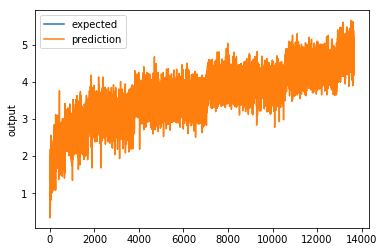

In [55]:
# Plot the chart
chart_regression(pred.flatten(),y_test_tf)

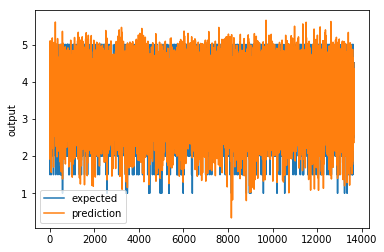

In [56]:
chart_regression(pred.flatten(),y_test_tf, sort=False)

### Tensorflow Classification

In [57]:
#y_oneHotEncode = pd.get_dummies(df_ready_for_sklearn['stars'])
#type(y_oneHotEncode)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(df_ready_for_sklearn, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [59]:
x_train['review_count_zscore'] = zscore(x_train['review_count'])
x_train[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53526,ygcX18rboNOaYnNmRCDytw,b'I drive 45 minutes from Cleveland to enjoy t...,4.0,30,"Restaurants, Cafes, Tea Rooms, Bubble Tea, Food",b'cute shop and helpful staff!'b'The greatest ...,6,-0.374402
16481,IB_aESRBh2cmYWSF6Fv0jQ,b'I was really happy with Spencer\'s when I pu...,3.0,94,"Home & Garden, Shopping, Appliances, Electronics",b'Best pricing in town.Next day delivery great...,4,-0.021752
21744,OI_lS_aamMgjnHqNlaO2rA,"b""For a post office, this location is pretty g...",2.5,21,"Public Services & Government, Local Services, ...","b""Kinda old school. Feels weird. Have to Stand...",3,-0.423993
49426,tyQWsZUSoMuoX6_5pcCE8Q,"b""Honestly the worst latte I've ever had. Got ...",4.5,108,"Coffee & Tea, Coffee Roasteries, Food",b'Cute simple coffee shop. Great coffee and th...,7,0.055390
23280,Q7rrhu3FJxTASTo46pT9vA,"b""It tastes great and the atmosphere is great ...",3.5,101,"Coffee & Tea, Food",b'$3 cappuccino is a pretty sweet deal. I have...,5,0.016819


In [60]:
x_test['review_count_zscore'] = zscore(x_test['review_count'])
x_test[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53763,yyiHkabQBtLifVTsO1r1kw,"b""I am not the biggest fan of Walmart but they...",3.0,37,"Food, Shopping, Grocery, Fashion, Drugstores, ...",b'Picking up some goodies for E.B.!'b'Rich wal...,4,-0.293785
50802,vZu12JAudoXBv3-i0JmSiQ,"b""I brought a watch strap in to get a few link...",3.0,29,"Shopping, Jewelry, Watch Repair, Local Service...",b'5 mins in and out for a battery replacement....,4,-0.330296
54033,zIpW3YlE9fFwyWOT5HGI6A,"b""Only giving one star cuz I have to. Terrible...",2.0,41,"Fast Food, Ice Cream & Frozen Yogurt, Restaura...","b""Get better employees and listen to what peop...",2,-0.275530
27076,UaL6yRGSv9fYCyn2DJLu8w,"b'Greek salad add avacado, very fresh very del...",4.5,42,"Food, Juice Bars & Smoothies, Restaurants, Cof...","b'Love this place. Good food, fresh as fuck ju...",7,-0.270966
14056,FML0YqZ7dLBBC3Suap4_4Q,"b""My favourite place in the city! Great vibe a...",4.0,296,"Nightlife, Restaurants, Tapas/Small Plates, Bars",b'Most of the food is made in house'b'All is g...,6,0.888237


In [61]:
#obtain tfidf score for reviews
#vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

reviews_matrix_train = vectorizer.fit_transform(x_train['all_reviews'])
reviews_tfidf_train = reviews_matrix_train.toarray()

reviews_matrix_test = vectorizer.transform(x_test['all_reviews'])
reviews_tfidf_test = reviews_matrix_test.toarray()

#vectorizer.get_feature_names()

In [62]:
#obtain tfidf score for tips
#vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

tips_matrix_train = vectorizer.fit_transform(x_train['all_tips'])
tips_tfidf_train = tips_matrix_train.toarray()

tips_matrix_test = vectorizer.transform(x_test['all_tips'])
tips_tfidf_test = tips_matrix_test.toarray()

vectorizer.get_feature_names()

['10',
 '11',
 '15',
 '20',
 '30',
 '50',
 '99',
 'absolutely',
 'amazing',
 'area',
 'ask',
 'atmosphere',
 'authentic',
 'available',
 'away',
 'awesome',
 'bad',
 'bar',
 'beautiful',
 'beef',
 'beer',
 'best',
 'better',
 'big',
 'bit',
 'bomb',
 'bread',
 'breakfast',
 'bring',
 'burger',
 'business',
 'busy',
 'buy',
 'came',
 'card',
 'cash',
 'cheap',
 'check',
 'cheese',
 'chicken',
 'chocolate',
 'clean',
 'close',
 'closed',
 'coffee',
 'cold',
 'come',
 'coming',
 'cool',
 'cream',
 'customer',
 'day',
 'deal',
 'decent',
 'definitely',
 'delicious',
 'did',
 'didn',
 'different',
 'dinner',
 'disappointed',
 'does',
 'don',
 'drink',
 'drinks',
 'drive',
 'early',
 'eat',
 'enjoy',
 'excellent',
 'experience',
 'extra',
 'family',
 'fantastic',
 'far',
 'fast',
 'favorite',
 'feel',
 'fish',
 'flavor',
 'food',
 'free',
 'fresh',
 'friday',
 'fried',
 'friendly',
 'friends',
 'fries',
 'fun',
 'getting',
 'going',
 'good',
 'got',
 'great',
 'green',
 'guys',
 'half',
 'ha

In [63]:
temp = x_train['review_count_zscore'].values
input_data_train = np.column_stack((reviews_tfidf_train, tips_tfidf_train))
input_data_train = np.column_stack((input_data_train, temp))
#input_data_train = np.column_stack((reviews_tfidf_train, temp))
#input_data_train.shape

temp = x_test['review_count_zscore'].values
input_data_test = np.column_stack((reviews_tfidf_test, tips_tfidf_test))
input_data_test = np.column_stack((input_data_test, temp))
#input_data_test = np.column_stack((reviews_tfidf_test, temp))
input_data_test.shape

(13665, 501)

In [64]:
type(input_data_train)

numpy.ndarray

In [65]:
#convert into dataframe
df_train = pd.DataFrame(input_data_train)
df_test = pd.DataFrame(input_data_test)
df_train['encoded_stars'] = y_train.values
df_test['encoded_stars'] = y_test.values
#df_train.dropna()
#missing_median(df_train, 'stars')
#missing_median(df_test, 'stars')

In [66]:
#df_train.reset_index(drop=True, inplace=True)
#y_train.reset_index(drop=True, inplace=True)
#df_train = pd.concat([df_train, y_train], axis=1)

#df_test.reset_index(drop=True, inplace=True)
#y_test.reset_index(drop=True, inplace=True)
#df_test = pd.concat([df_test, y_test], axis=1)
#df_test


In [67]:
x_train_tf,y_train_tf = to_xy(df_train,'encoded_stars')

In [68]:
x_test_tf,y_test_tf = to_xy(df_test,'encoded_stars')

In [69]:
y_test_tf.shape

(13665, 9)

In [82]:
checkpointer = ModelCheckpoint(filepath=".\classification.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(10):
    print(i)
    
    #Build network
    model = Sequential()

    model.add(Dense(1000, input_dim=x_train_tf.shape[1], kernel_initializer=keras.initializers.he_normal(seed=5), activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dropout(0.72)) #dropout layer
    model.add(Dense(1000, kernel_initializer=keras.initializers.he_normal(seed=10), activation='relu')) # Hidden 2
    model.add(Dropout(0.72)) #dropout layer
    #model.add(Dense(20+i, activation='relu')) # Hidden 4
    model.add(Dense(y_train_tf.shape[1], kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=20), activation='softmax')) # Output

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    #checkpointer = ModelCheckpoint(filepath=".\lowest_error.hdf5", verbose=0, save_best_only=True) # save best model


    model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=2,epochs=100, batch_size=512, validation_split=0.1)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\classification.hdf5') # load weights from best model

0
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Train on 40992 samples, validate on 13665 samples
Epoch 1/100
 - 3s - loss: 1.6033 - acc: 0.3347 - val_loss: 1.1979 - val_acc: 0.4906
Epoch 2/100
 - 1s - loss: 1.1931 - acc: 0.4734 - val_loss: 1.0033 - val_acc: 0.5725
Epoch 3/100
 - 1s - loss: 1.0664 - acc: 0.5280 - val_loss: 0.9388 - val_acc: 0.5953
Epoch 4/100
 - 1s - loss: 1.0047 - acc: 0.5535 - val_loss: 0.9128 - val_acc: 0.6063
Epoch 5/100
 - 1s - loss: 0.9666 - acc: 0.5755 - val_loss: 0.8894 - val_acc: 0.6141
Epoch 6/100
 - 1s - loss: 0.9359 - acc: 0.5865 - val_loss: 0.8772 - val_acc: 0.6200
Epoch 7/100
 - 1s - loss: 0.9135 - acc: 0.5972 - val_loss: 0.8659 - val_acc: 0.6218
Epoch 8/100
 - 1s - loss: 0.8932 - acc: 0.6089 - val_loss: 0.8589 - val_acc: 0.6288
Epoch 9/100
 - 1s - loss: 0.8765 - acc: 0.6156 - val_loss: 0.8571 - val_acc: 0.6247
Epoch 10/100
 - 1s - loss: 0.8662 - acc: 0.6205 - val_loss: 0.8465 - val_acc: 0.6322
Epoch 11/100
 - 1s - loss:

Epoch 18/100
 - 1s - loss: 0.7564 - acc: 0.6688 - val_loss: 0.8419 - val_acc: 0.6383
Epoch 19/100
 - 1s - loss: 0.7374 - acc: 0.6820 - val_loss: 0.8470 - val_acc: 0.6340
Epoch 20/100
 - 1s - loss: 0.7291 - acc: 0.6835 - val_loss: 0.8508 - val_acc: 0.6345
Epoch 21/100
 - 1s - loss: 0.7233 - acc: 0.6876 - val_loss: 0.8507 - val_acc: 0.6354
Epoch 22/100
 - 1s - loss: 0.7090 - acc: 0.6930 - val_loss: 0.8541 - val_acc: 0.6375
Epoch 23/100
 - 1s - loss: 0.6998 - acc: 0.6962 - val_loss: 0.8556 - val_acc: 0.6378
Epoch 24/100
 - 1s - loss: 0.6852 - acc: 0.7055 - val_loss: 0.8605 - val_acc: 0.6363
Epoch 25/100
 - 1s - loss: 0.6775 - acc: 0.7128 - val_loss: 0.8671 - val_acc: 0.6392
Epoch 26/100
 - 1s - loss: 0.6648 - acc: 0.7131 - val_loss: 0.8703 - val_acc: 0.6375
Epoch 00026: early stopping
4
Train on 40992 samples, validate on 13665 samples
Epoch 1/100
 - 3s - loss: 1.5994 - acc: 0.3354 - val_loss: 1.1815 - val_acc: 0.4986
Epoch 2/100
 - 1s - loss: 1.1938 - acc: 0.4728 - val_loss: 1.0021 - val

 - 1s - loss: 0.8235 - acc: 0.6395 - val_loss: 0.8473 - val_acc: 0.6289
Epoch 14/100
 - 1s - loss: 0.8097 - acc: 0.6452 - val_loss: 0.8425 - val_acc: 0.6320
Epoch 15/100
 - 1s - loss: 0.7915 - acc: 0.6543 - val_loss: 0.8440 - val_acc: 0.6381
Epoch 16/100
 - 1s - loss: 0.7778 - acc: 0.6601 - val_loss: 0.8446 - val_acc: 0.6344
Epoch 17/100
 - 1s - loss: 0.7692 - acc: 0.6667 - val_loss: 0.8396 - val_acc: 0.6348
Epoch 18/100
 - 1s - loss: 0.7575 - acc: 0.6680 - val_loss: 0.8413 - val_acc: 0.6376
Epoch 19/100
 - 1s - loss: 0.7494 - acc: 0.6761 - val_loss: 0.8516 - val_acc: 0.6346
Epoch 20/100
 - 1s - loss: 0.7315 - acc: 0.6833 - val_loss: 0.8542 - val_acc: 0.6318
Epoch 21/100
 - 1s - loss: 0.7204 - acc: 0.6888 - val_loss: 0.8471 - val_acc: 0.6370
Epoch 22/100
 - 1s - loss: 0.7142 - acc: 0.6923 - val_loss: 0.8466 - val_acc: 0.6407
Epoch 23/100
 - 1s - loss: 0.6993 - acc: 0.6983 - val_loss: 0.8585 - val_acc: 0.6351
Epoch 24/100
 - 1s - loss: 0.6922 - acc: 0.7012 - val_loss: 0.8692 - val_acc: 

In [78]:
# Measure accuracy
pred = model.predict(x_test_tf)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test_tf,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))
y_test_tf

Final accuracy: 0.638931577021588


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

[[   0   22    2    0    0    0    0    0    0]
 [   0   88   75    6    0    0    0    0    0]
 [   0   30  267  171   26    0    1    0    0]
 [   0    5   86  470  446   33    0    0    0]
 [   0    1   14  141 1269  622   27    1    0]
 [   0    0    0    6  376 2258  575   20    1]
 [   0    0    0    0   17  715 2415  367    8]
 [   0    0    0    0    0   26  624 1485  221]
 [   0    0    0    0    0    0   12  257  479]]
Ploting confusion matrix


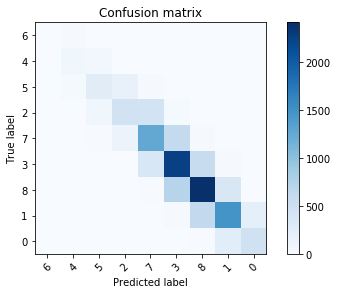

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.60      0.52      0.56       169
           2       0.60      0.54      0.57       495
           3       0.59      0.45      0.51      1040
           4       0.59      0.61      0.60      2075
           5       0.62      0.70      0.66      3236
           6       0.66      0.69      0.67      3522
           7       0.70      0.63      0.66      2356
           8       0.68      0.64      0.66       748

   micro avg       0.64      0.64      0.64     13665
   macro avg       0.56      0.53      0.54     13665
weighted avg       0.64      0.64      0.64     13665



C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, df_ready_for_sklearn['encoded_stars'].unique())
plt.show()


print(classification_report(y_true, pred))

# Linear Regression

Preparing data for training/testing

In [ ]:
#Merge reviews_tfidf, tips_tfidf and review_count into one array for input
temp = df_ready_for_sklearn['review_count_zscore'].values
input_data = np.column_stack((reviews_tfidf, tips_tfidf))
input_data = np.column_stack((input_data, temp))
input_data.shape

In [ ]:
#split into train/test data
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [ ]:
test_data = input_data[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data[test_loc[i]], axis=0)
test_data.shape

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.linear_model import LinearRegression

# instantiate the model (using the default parameters)
linreg = LinearRegression()

# fit the model with data
linreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Linear = linreg.predict(test_data)

In [ ]:
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Linear[i], test_true_stars[i]))

### Support Vector Machine

In [ ]:
#split into train/test data
#using encoded stars because classification problem
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC(dual=False)
clf.fit(x_train, y_train)

y_pred_SVM = clf.predict(test_data)

In [ ]:
y_pred_SVM = le.inverse_transform(y_pred_SVM)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_SVM[i], test_true_stars[i]))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Logistic = logreg.predict(test_data)

In [ ]:
y_pred_Logistic = le.inverse_transform(y_pred_Logistic)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Logistic[i], test_true_stars[i]))

### Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the value K=10)
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model with data
knn.fit(x_train, y_train)

In [ ]:
# predict the response for new observations
y_neighbor = knn.predict(test_data)

In [ ]:
y_neighbor = le.inverse_transform(y_neighbor)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_neighbor[i], test_true_stars[i]))

### Multinomial Naive Bayes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

temp = scaler.fit_transform(df_ready_for_sklearn['review_count'].values.reshape(1, -1))

input_data_MNB = np.column_stack((reviews_tfidf, tips_tfidf))
input_data_MNB = np.column_stack((input_data_MNB, temp.reshape(-1,1)))

input_data_MNB

In [ ]:
test_data = input_data_MNB[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data_MNB[test_loc[i]], axis=0)
test_data.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input_data_MNB, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# instantiate the model (using the default parameters)
mnb = MultinomialNB()

# fit the model with data
mnb.fit(x_train, y_train)

# predict the response for new observations
y_mnb = mnb.predict(test_data)

In [ ]:
y_mnb = le.inverse_transform(y_mnb)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_mnb[i], test_true_stars[i]))